# Alpsko smučanje

## Priprava podatkov

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as py
#import scipy

# Make the graphs a bit prettier, and bigger
#pd.set_option('display.mpl_style', 'default')
#plt.rcParams['figure.figsize'] = (15, 5)


# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

Najprej sem spletne strani [FIS](http://www.fis-ski.com/alpine-skiing/athletes/) pobrala podatke o smučarjih in njihovih id številkah na spletišču FIS. Id-je sem potrebovala za sestavljanje url naslovov posameznih športnikov. Zbrane podatke sem nato spravila v datoteko smucarji.csv.

In [2]:
pot="csv-datoteke/smucarji.csv"
smucarji = pd.read_csv(pot, index_col='id')

Tabela izgleda tako:

In [3]:
smucarji[:10]

,ime,drzava,smuci
id,,,
70206,ABDERHALDEN Marianne,SUI,Head
148274,AERNI Luca,SUI,Salomon
166907,AGER Christina,AUT,Atomic
137008,AGNELLI Nicole,ITA,Elan
139437,ALOPINA Ksenia,RUS,Rossignol
163567,ALPHAND Estelle,FRA,Dynastar
125750,ANKENY Michael,USA,Nordica
80000,BAECK Axel,SWE,Rossignol
120086,BAILET Margot,FRA,Salomon


Nato sem za vsakega od tekmovalcev s strani z njegovimi rezultati (npr. [Eva-Maria Brem](http://data.fis-ski.com/dynamic/athlete-biography.html?sector=AL&listid=&competitorid=94808&type=result&rec_start=0&limit=100)) pobrala podatke o vsaki tekmi: datum, prizorišče, disciplino, uvrstitev, zaostanek.

In [4]:
pot_brem = "csv-datoteke/BREM  Eva-Maria.csv"
brem = pd.read_csv(pot_brem, parse_dates=['datum'])

Tabela za Evo-Mario Brem:

In [5]:
brem[:10]

,datum,kraj,disciplina,mesto
0,2016-03-20,St. Moritz,Giant Slalom,4
1,2016-07-03,Jasna,Giant Slalom,1
2,2016-06-03,Jasna,Slalom,26
3,2016-02-15,Crans Montana,Slalom,DNQ1
4,2016-01-30,Maribor,Giant Slalom,4
5,2016-01-17,Flachau,Giant Slalom,4
6,2016-01-15,Flachau,Slalom,26
7,2016-12-01,Flachau,Slalom,26
8,2016-05-01,Santa Caterina Valfurva,Slalom,26
9,2015-12-29,Lienz,Slalom,21


Žal si z datumi ne bomo mogli pomagati, saj so na spletni strani z rezultati zapisani v različnih formatih. Kot primer si lahko ogledamo prvo in drugo vrstico zgornje tabele. Iz prve vrstice lahko sklepamo, da je zapis v obliki YYYY-MM-DD, kar pa bi pomenilo, da je bila tekma v drugi vrstici izvedena 3. julija 2016, kar pa iz očitnih razlogov ni res. Tega žal ne morem popraviti.

Da lahko primerjam tudi tekmovalce med seboj, sem naredila še csv datoteko 'vse.csv', v kateri zapišem vse podatke kot zgoraj in id tekmovalca:

In [6]:
pot1 ="csv-datoteke/vse.csv"
vse = pd.read_csv(pot1, parse_dates=['datum'])

Tabela izgleda tako:

In [7]:
vse[197:203]

,id,datum,kraj,disciplina,mesto
197,163567,2014-07-03,Are,Giant Slalom,DNQ1
198,163567,2014-06-03,Are,Giant Slalom,DNQ1
199,163567,2013-09-03,Ofterschwang,Giant Slalom,DNF1
200,125750,2016-06-03,Kranjska Gora,Slalom,DNQ1
201,125750,2016-04-03,Kranjska Gora,Giant Slalom,DNS1
202,125750,2016-02-14,Yuzawa Naeba,Slalom,DNQ1


V kasnejši analizi se pojavi težava, da so podatki o uvrstitvi lahko številke ali besedilo (npr. DNQ1, DNF1, DSQ2 in DNS1), ki označuje odstope, diskvalifikacije in podobne anomalije.
Zato tabelam dodamo nov stolpec __mesto1__, kjer besedilne podatke identificiramo z 0. Tu nas ne zanima, zakaj tekmovalec ni osvojil točk.

In [8]:
def pretvori(bes):
    if bes in ['DNQ1', 'DNF1', 'DSQ2', 'DNS1','DNF2','DSQ1','DNS2','DNQ2','DNF','DNC1','DSQ','DNS']:
        return 0
    else:
        return int(bes)

Če bomo želeli delati analizo skupnega seštevka, moramo pretvoriti mesto tudi v točke. Definiramo seznam 'tocke', v katerega na i-to mesto (i teče od 0 do 30) zapišemo, koliko točk tekmovalec dobi za osvojeno i-to mesto. Nato napišemo še funkcijo, ki nam pretvori mesto v osvojene točke.

In [9]:
tocke=[0,100,80,60,50,45,40,36,32,29,26,24,22,20,18,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]

def pretvori_2(bes):
    if bes in ["DNQ1", "DNF1", "DSQ2", "DNS1", "DNF2"]:
        return 0
    else:
        if int(bes) > 30:
            return 0
        else:
            return tocke[int(bes)];        

Tabelam zdaj dodamo stolpce:

In [10]:
vse['mesto1'] = vse['mesto'].map(pretvori)
brem['mesto1'] = brem['mesto'].map(pretvori)
vse['tocke'] = vse['mesto1'].map(pretvori_2)
brem['tocke'] = brem['mesto1'].map(pretvori_2)
brem[:5]

,datum,kraj,disciplina,mesto,mesto1,tocke
0,2016-03-20,St. Moritz,Giant Slalom,4,4,50
1,2016-07-03,Jasna,Giant Slalom,1,1,100
2,2016-06-03,Jasna,Slalom,26,26,5
3,2016-02-15,Crans Montana,Slalom,DNQ1,0,0
4,2016-01-30,Maribor,Giant Slalom,4,4,50


Zgornja tabela prikazuje predelano tabelo za Evo-Mario Brem. Enako smo naredili s tabelo z vsemi podatki:

In [11]:
vse[2024:2028]

,id,datum,kraj,disciplina,mesto,mesto1,tocke
2024,94808,2007-01-14,Altenmarkt-Zauchensee,Super Combined,29,29,2
2025,94808,2005-12-29,Lienz,Slalom,DNQ1,0,0
2026,128892,2016-05-03,Kranjska Gora,Giant Slalom,26,26,5
2027,128892,2016-04-03,Kranjska Gora,Giant Slalom,DNQ1,0,0


## Analiza

### Analiza dosežkov Eve-Marie Brem

Pa si poglejmo, v katerih disciplinah najpogosteje tekmuje Eva-Maria Brem:

In [12]:
brem['disciplina'].value_counts()

Giant Slalom      67
Slalom            49
Super Combined     8
Super G            2
Downhill           1
Name: disciplina, dtype: int64

Eva-Maria Brem je torej najpogosteje tekmuje v slalomu in veleslalomu. Ponazorimo to še z grafom:

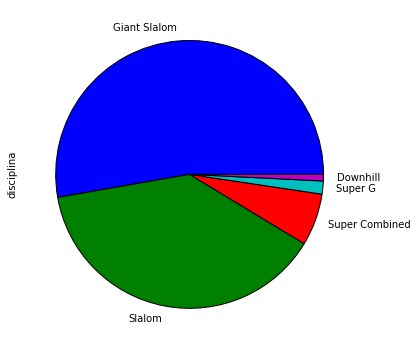

In [13]:
brem['disciplina'].value_counts().plot(kind='pie', figsize=(6,6))

Čeprav najpogosteje tekmuje v slalomu in veleslalomu, pa to nista nujno disciplini, v katerih dosega najboljše rezultate. Najprej si poglejmo, kakšni so njeni rezultati v slalomu in nato še veleslalomu:

In [14]:
slalom = brem['disciplina'] == 'Slalom'
brem[slalom][:10]

,datum,kraj,disciplina,mesto,mesto1,tocke
2,2016-06-03,Jasna,Slalom,26,26,5
3,2016-02-15,Crans Montana,Slalom,DNQ1,0,0
6,2016-01-15,Flachau,Slalom,26,26,5
7,2016-12-01,Flachau,Slalom,26,26,5
8,2016-05-01,Santa Caterina Valfurva,Slalom,26,26,5
9,2015-12-29,Lienz,Slalom,21,21,10
12,2015-12-13,Are,Slalom,17,17,14
14,2015-11-29,"Aspen, CO",Slalom,DNQ1,0,0
15,2015-11-28,"Aspen, CO",Slalom,20,20,11
19,2015-03-14,Are,Slalom,27,27,4


In [15]:
veleslalom = brem['disciplina'] == 'Giant Slalom'
brem[veleslalom][:10]

,datum,kraj,disciplina,mesto,mesto1,tocke
0,2016-03-20,St. Moritz,Giant Slalom,4,4,50
1,2016-07-03,Jasna,Giant Slalom,1,1,100
4,2016-01-30,Maribor,Giant Slalom,4,4,50
5,2016-01-17,Flachau,Giant Slalom,4,4,50
10,2015-12-28,Lienz,Giant Slalom,4,4,50
11,2015-12-20,Courchevel,Giant Slalom,1,1,100
13,2015-12-12,Are,Giant Slalom,2,2,80
16,2015-11-27,"Aspen, CO",Giant Slalom,2,2,80
17,2015-10-24,Soelden,Giant Slalom,8,8,32
18,2015-03-22,Meribel,Giant Slalom,2,2,80


Iz tabel je razvidno, da so njeni razultati v slalomu v vačini na repu trideseterice, med tem ko se v veleslalomu uvršča med 5 najboljših. To se še lepše vidi z grafov:

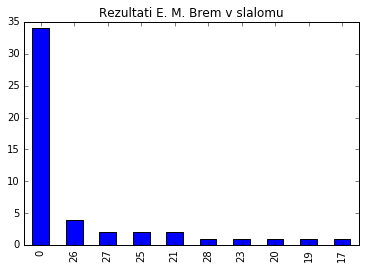

In [16]:
brem[slalom]['mesto1'].value_counts().plot(kind='bar', title="Rezultati E. M. Brem v slalomu")

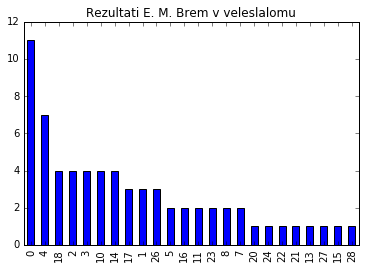

In [17]:
brem[veleslalom]['mesto1'].value_counts().plot(kind='bar', title='Rezultati E. M. Brem v veleslalomu')

Poglejmo še koliko točk je v povprečju osvojila pri posamezni disciplini, da določimo njeno "paradno disciplino".

In [18]:
brem.groupby(['disciplina'])['tocke'].sum() / brem['tocke'].sum()

disciplina
Downhill          0.00000
Giant Slalom      0.92259
Slalom            0.05258
Super Combined    0.02483
Super G           0.00000
Name: tocke, dtype: float64

Veleslalom je torej precej očitno disciplina, ki ji prinaša največ točk.

Poglejmo si še podatke za letošnjo sezono. Prva tekma je bila 24. 10. 2015 v Soeldnu.

In [19]:
prvi_del = brem[brem['datum'].dt.year == 2016]
drugi_del = brem[(brem['datum'].dt.month > 9) & (brem['datum'].dt.year == 2015)]
tabela = prvi_del.append(drugi_del)
tabela

,datum,kraj,disciplina,mesto,mesto1,tocke
0,2016-03-20,St. Moritz,Giant Slalom,4,4,50
1,2016-07-03,Jasna,Giant Slalom,1,1,100
2,2016-06-03,Jasna,Slalom,26,26,5
3,2016-02-15,Crans Montana,Slalom,DNQ1,0,0
4,2016-01-30,Maribor,Giant Slalom,4,4,50
5,2016-01-17,Flachau,Giant Slalom,4,4,50
6,2016-01-15,Flachau,Slalom,26,26,5
7,2016-12-01,Flachau,Slalom,26,26,5
8,2016-05-01,Santa Caterina Valfurva,Slalom,26,26,5
9,2015-12-29,Lienz,Slalom,21,21,10


Ker si z datumi ne moremo pomagati, glejmo le dosežena mesta:

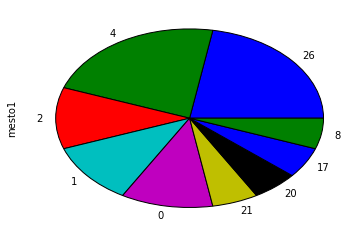

In [20]:
tabela['mesto1'].value_counts().plot(kind='pie')

Podoben graf si poglejmo posebej še za veleslalom:

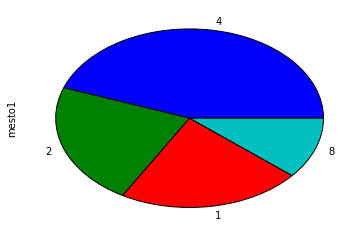

In [21]:
tabela[tabela['disciplina'] == 'Giant Slalom']['mesto1'].value_counts().plot(kind='pie')

Opazimo, da ena uvrstitev odstopa: to je njena prva uvrstitev v sezoni: "le" 8. mesto v Soeldnu 24. 10. 2015.

Poglejmo si še analizo po prizoriščih. Postavimo si vprašanje, kje dosega boljše rezultate.

In [22]:
po_krajih = brem.groupby(['kraj'])['tocke'].sum() / brem['tocke'].sum()
po_krajih.nlargest(7)

kraj
Are           0.199611
Aspen         0.083739
Courchevel    0.070107
Soelden       0.064752
Jasna         0.051120
Lienz         0.050633
Aspen, CO     0.047712
Name: tocke, dtype: float64

V Are-ju je osvojila kar 20 % vseh svojih točk. Ali tam dosega tudi najvišja mesta?

In [23]:
po_krajih1 = brem.groupby(['kraj'])['tocke'].mean()
po_krajih1.nlargest(7)

kraj
Meribel         80.000000
Jasna           52.500000
Lenzerheide     49.000000
Panorama, BC    45.000000
Courchevel      36.000000
Are             27.333333
Schladming      26.000000
Name: tocke, dtype: float64

Najvišja mesta očitno dosega v Meribelu. Da rezultate še bolje razložimo, poglejmo, koliko tekem se je Eva-Maria Brem udeležila v posameznem kraju.

In [24]:
brem.groupby(['kraj']).size().sort_values(ascending = False)

kraj
Are                        15
Maribor                     9
Aspen                       8
Soelden                     8
Ofterschwang                8
Flachau                     8
Lienz                       8
St. Moritz                  7
Aspen, CO                   5
Zagreb                      4
Semmering                   4
Courchevel                  4
Levi                        3
Val d'Isere                 3
Kranjska Gora               3
Crans Montana               3
Cortina d'Ampezzo           2
Bormio                      2
Jasna                       2
Lenzerheide                 2
Kuehtai in Tirol            2
La Molina                   2
Soldeu-Grandvalira          2
Spindleruv Mlyn             2
Altenmarkt-Zauchensee       2
Garmisch Partenkirchen      1
Meribel                     1
Panorama, BC                1
Santa Caterina Valfurva     1
Schladming                  1
Beaver Creek                1
St. Anton/Arlberg           1
Tarvisio                    1
Arber

V Are-ju se E. M. Brem je udeležila daleč največ tekem, zato ni čudno, da je tam osvojila največ točk. Prav tako ne moremo trditi, da je Meribel njeno "najboljše" prizorišče, saj je tam tekmovala na le eni tekmi.

### Analiza več tekmovalcev

V tem razdelku bomo imeli nekaj težav, saj na strani, iz katere pobiramo podatke, ni zapisa o spolu tekmovalca.  
Najprej pa poglejmo rezultate za sezono 2015/16.

In [25]:
sezona = vse[vse['datum'].dt.year == 2016]
drugi_del_vse = vse[(vse['datum'].dt.month > 9) & (vse['datum'].dt.year == 2015)]
sezona.append(drugi_del)[40:46]

,datum,disciplina,id,kraj,mesto,mesto1,tocke
232,2016-10-01,Slalom,80000,Adelboden,22,22,9
233,2016-06-01,Slalom,80000,Santa Caterina Valfurva,DNQ1,0,0
293,2016-03-16,Downhill,120086,St. Moritz,10,10,26
294,2016-03-13,Alpine combined,120086,Lenzerheide,18,18,13
295,2016-12-03,Super G,120086,Lenzerheide,34,34,0
296,2016-02-28,Alpine combined,120086,Soldeu- El Tarter,DNF2,0,0


Zanima nas, koliko nastopov so zbrali tekmovalci v letošnji sezoni. Prikazujemo število nastopov za 10 tekmovalcev.

In [26]:
sezona.groupby(['id']).size()[:10]

id
2820      2
4588      1
5469      6
8288      8
10054    13
10394    11
11090    13
11353     6
11929    10
13418     3
dtype: int64

In [27]:
sezona.groupby(['id']).size().max()

21

Tekmovalec ali tekmovalka z največ nastopi je nastopila 21-krat. Kdo pa je to?

In [28]:
nova = sezona.groupby(['id']).size()
nova.nlargest(6)

id
125871    21
127048    21
70282     20
106332    20
108784    20
27657     19
dtype: int64

To sta torej dva tekmovalca in sicer z id številkama 125871 in 127048 - Lara Gut in Alexis Pinturault.

In [29]:
print(smucarji.get_value(index = 125871, col = 'ime'), ", ", smucarji.get_value(index = 127048, col = 'ime'))

GUT  Lara ,  PINTURAULT  Alexis


Kdo pa je osvojil največ točk? Poglejmo 10 najboljših:

In [30]:
sezona.groupby(['id']).agg({'tocke':sum}).nlargest(columns = 'tocke', n = 10)

,tocke
id,
106332,1174
127048,1079
154950,933
125871,878
104502,823
27657,755
30368,749
107164,716
109079,658


Še njihova imena:

In [31]:
naj = [106332,127048,154950,125871,104502,27657,30368,107164,109079,137380]
for i in naj:
    print(i,': ', smucarji.get_value(index = i, col = 'ime'))

106332 :  HIRSCHER  Marcel
127048 :  PINTURAULT  Alexis
154950 :  KRISTOFFERSEN  Henrik
125871 :  GUT  Lara
104502 :  REBENSBURG  Viktoria
27657 :  JANSRUD  Kjetil
30368 :  VONN  Lindsey
107164 :  WEIRATHER  Tina
109079 :  PARIS  Dominik
137380 :  KILDE  Aleksander Aamodt


### Analiza narodnosti

Zanima nas, koliko je smučarjev določene narodnosti. Najprej jih preštejmo, nato pa ponazorimo to z grafom:

In [32]:
smucarji['drzava'].value_counts().head(10)

AUT    61
SUI    45
ITA    42
FRA    39
USA    31
GER    26
SWE    20
NOR    18
CAN    18
SLO    15
Name: drzava, dtype: int64

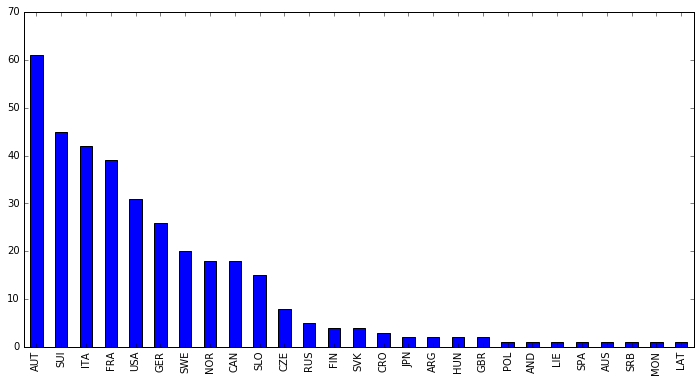

In [33]:
smucarji['drzava'].value_counts().plot(kind='bar', figsize = (12,6))

### Analiza smuči

Najprej si oglejmo, katere znamke smuči so najpogostejše v svetovnem pokalu:

In [34]:
smucarji['smuci'].value_counts()

Head          76
Rossignol     68
Fischer       48
Atomic        43
Voelkl        32
Salomon       25
Stoeckli      20
Nordica       14
Dynastar       9
Ni_podatka     9
Blizzard       6
Elan           4
Hart           1
Name: smuci, dtype: int64

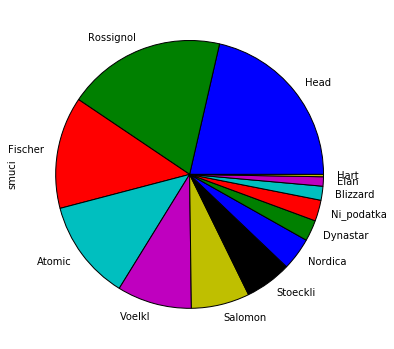

In [35]:
smucarji['smuci'].value_counts().plot(kind='pie', figsize=(6,6))

Poglejmo, predstavniki katerih držav uporabljajo smuči Head (in koliko jih je):

To do: naredi graf, ki bo prikazal to za vse smuči.

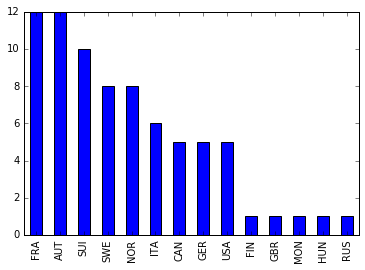

In [36]:
smucarji[smucarji['smuci'] == "Head"]['drzava'].value_counts().plot(kind='bar')

Podobno si lahko pogledamo, katerim proizvajalcem smuči najbolj zaupajo smučarji iz avstrije:

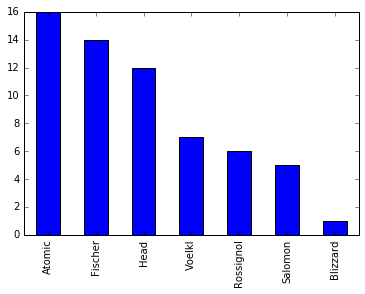

In [37]:
smucarji[smucarji['drzava'] == "AUT"]['smuci'].value_counts().plot(kind='bar')

Z analizo enega samega proizvajalca oz. ene same države ne dobimo širše slike, zato si oglejmo graf, ki za vsako državo prikaže, smuči katerega proizvajalca uporabljajo njeni reprezentanti.

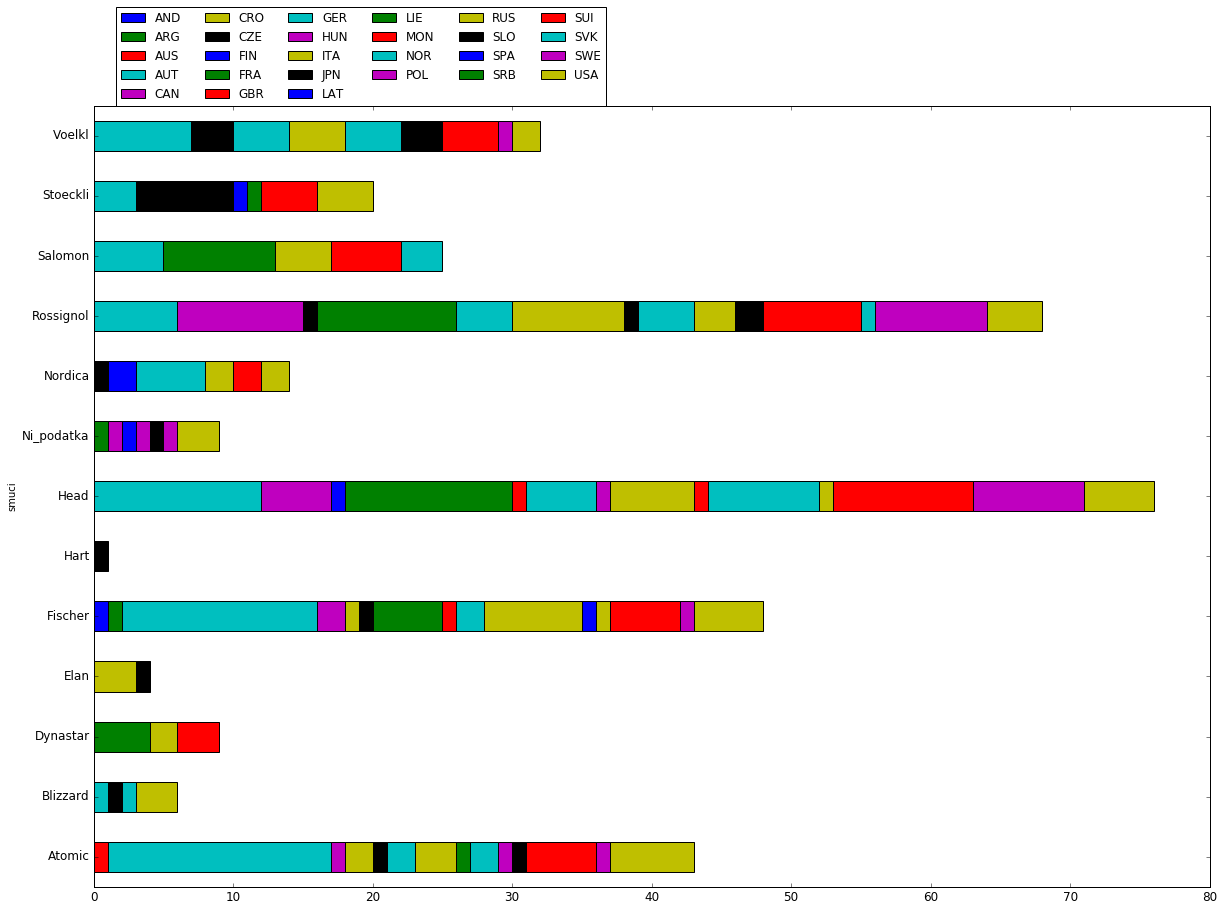

In [38]:
oboje = smucarji.groupby(['smuci','drzava']).size()
priprava = oboje.unstack().plot(kind='barh', stacked=True, figsize=(20, 14), fontsize=12)
priprava.legend(loc=(0.02,1), ncol=6)